In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-10-08 23:20:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  76.7MB/s    in 0.9s    

2020-10-08 23:20:46 (76.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.892.jpg', 'cat.205.jpg', 'cat.577.jpg', 'cat.221.jpg', 'cat.313.jpg', 'cat.209.jpg', 'cat.304.jpg', 'cat.597.jpg', 'cat.537.jpg', 'cat.245.jpg']
['dog.697.jpg', 'dog.331.jpg', 'dog.668.jpg', 'dog.131.jpg', 'dog.280.jpg', 'dog.98.jpg', 'dog.202.jpg', 'dog.544.jpg', 'dog.535.jpg', 'dog.861.jpg']


In [6]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)),'\n')

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000 

total validation cat images : 500
total validation dog images : 500


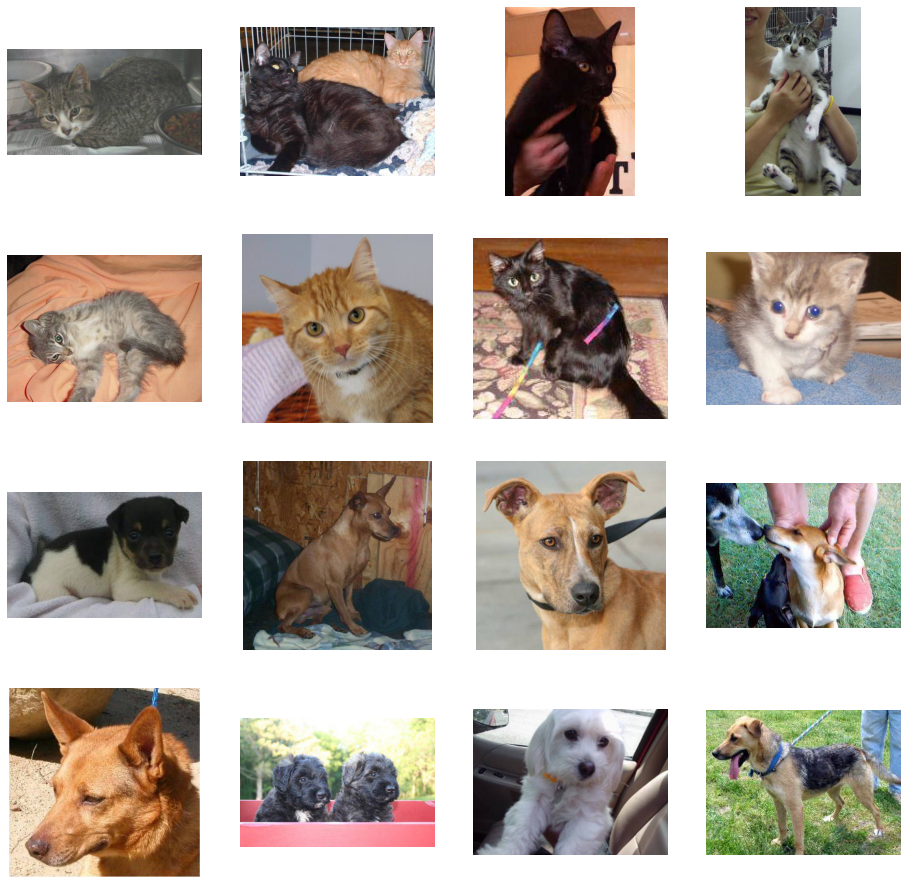

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Malla de imagenes 4x4
nrows = 4
ncols = 4

# Indice aleatorio para iterar sobre las imagenes
pic_index = np.random.randint(len(os.listdir(train_cats_dir))-8) 

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# Tomar hilera de 8 desde índice elegido
pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [8]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalizar Datos
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# --------------------
# Flujo de imagenes de entrenamiento en grupos de 20, escalando a 150x150 usando train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flujo de imagenes de validación en grupos de 20, escalando a 150x150 usando test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=1)

Epoch 1/15
100/100 [==============================] - 10s 98ms/step - loss: 0.8691 - accuracy: 0.5495 - val_loss: 0.6669 - val_accuracy: 0.6160
Epoch 2/15
100/100 [==============================] - 10s 96ms/step - loss: 0.6695 - accuracy: 0.6345 - val_loss: 0.6063 - val_accuracy: 0.6790
Epoch 3/15
100/100 [==============================] - 10s 96ms/step - loss: 0.5933 - accuracy: 0.6930 - val_loss: 0.5969 - val_accuracy: 0.6990
Epoch 4/15
100/100 [==============================] - 10s 96ms/step - loss: 0.4965 - accuracy: 0.7665 - val_loss: 0.5662 - val_accuracy: 0.7040
Epoch 5/15
100/100 [==============================] - 10s 96ms/step - loss: 0.4130 - accuracy: 0.8220 - val_loss: 0.6622 - val_accuracy: 0.7140
Epoch 6/15
100/100 [==============================] - 10s 96ms/step - loss: 0.3225 - accuracy: 0.8670 - val_loss: 0.6160 - val_accuracy: 0.7240
Epoch 7/15
100/100 [==============================] - 10s 96ms/step - loss: 0.2535 - accuracy: 0.9040 - val_loss: 0.7556 - val_accuracy:

In [13]:
from google.colab import files
from keras.preprocessing import image

#Cargar imagen desde Colab
uploaded=files.upload()

for fn in uploaded.keys():
 
    # Cargar imagen
    path='/content/' + fn
    img=image.load_img(path, target_size=(150, 150))
    
    #Preprocesar Imagen
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    # Usar Modelo (Predecir Imagen)
    classes = model.predict(images, batch_size=10)
    # Mostrar resultados
    print(classes)
    #Clasificar
    if classes[0]>0:
      print(fn + " Es un Perro")

    else:
      print(fn + " Es un Gato")

In [14]:
preds=model.predict(validation_generator)
print(preds[:10])

[[9.8728347e-01]
 [1.1992173e-08]
 [7.6587307e-01]
 [9.9754012e-01]
 [6.0545113e-03]
 [9.9999118e-01]
 [5.1405567e-01]
 [9.9976760e-01]
 [2.0226074e-04]
 [5.8047252e-08]]


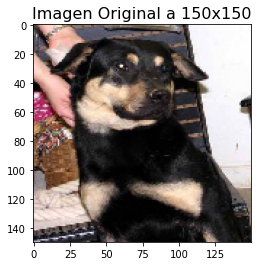

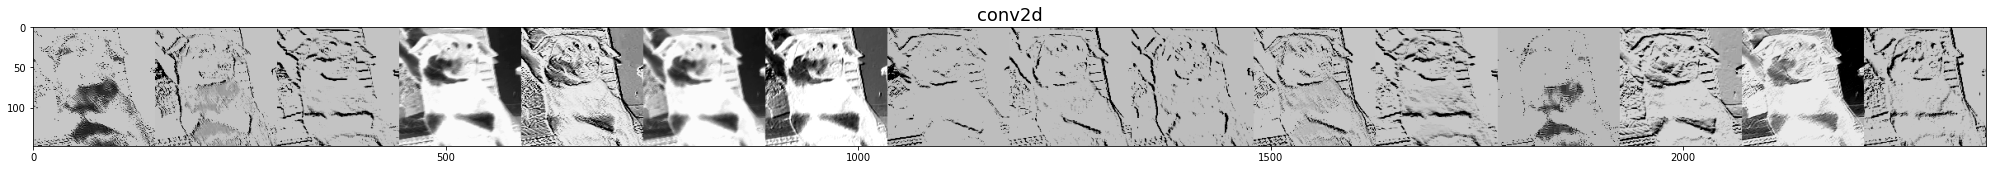

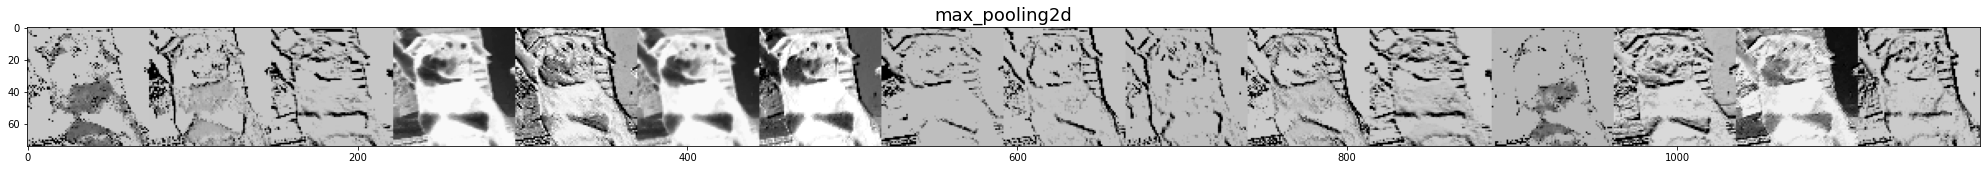

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


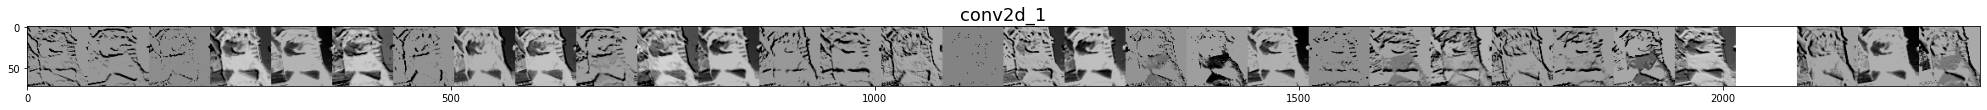

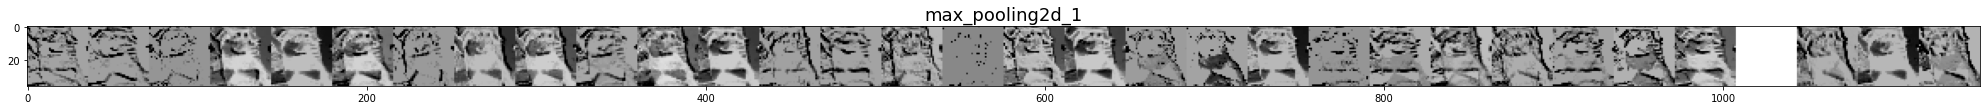

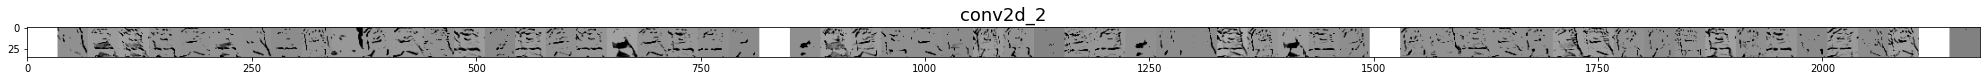

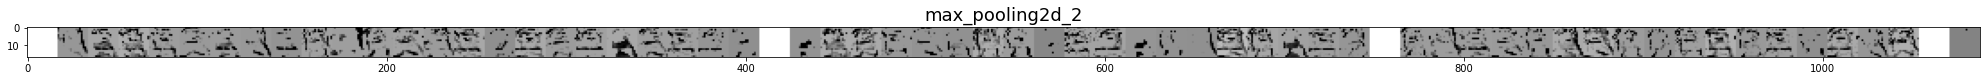

In [15]:
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[:-3]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Mostrar Imagen Original
plt.figure()
plt.imshow(img)
plt.grid(False)
plt.title("Imagen Original a 150x150",fontsize=16)

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

      #-------------------------------------------
      # Just do this for the conv / maxpool layers, not the fully-connected layers
      #-------------------------------------------
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))

      #-------------------------------------------------
      # Postprocess the feature to be visually palatable
      #-------------------------------------------------
      for i in range(n_features):
          x  = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std ()
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 35. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title (layer_name, fontsize=18)
    plt.grid (False)
    plt.imshow(display_grid, aspect='auto', cmap='binary') 
    plt.show()

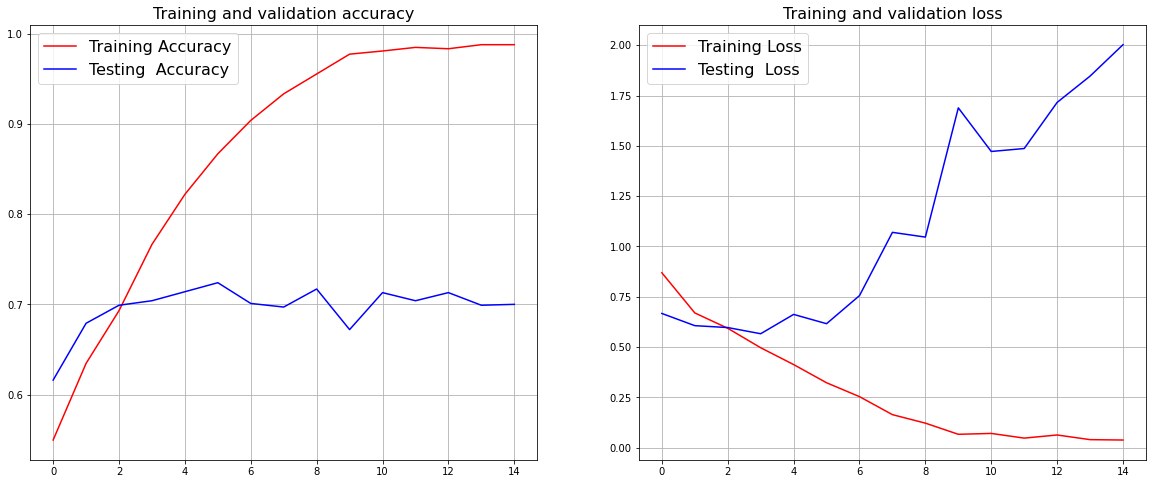

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs


plt.figure(figsize=(20,8))
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.subplot(121)
plt.plot  ( epochs,     acc,'r',label='Training Accuracy' )
plt.plot  ( epochs, val_acc,'b',label='Testing  Accuracy' )
plt.title ('Training and validation accuracy',fontsize=16)
plt.grid()
plt.legend(fontsize=16)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.subplot(122)
plt.plot  ( epochs,     loss,'r',label='Training Loss' )
plt.plot  ( epochs, val_loss,'b',label='Testing  Loss' )
plt.title ('Training and validation loss',fontsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.show()